In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump, load
import tensorflow.lite as tf_lite # for saving a lightweight model

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    plot_confusion_matrix, confusion_matrix, roc_auc_score, make_scorer
)
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from skimage.feature import hog
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.transform import resize

from skopt import BayesSearchCV
from kerastuner import HyperModel, Hyperband

from imblearn.over_sampling import SMOTE

np.random.seed(42)

In [2]:
class ResizeTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, shape=(128,128)):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array([resize(img, output_shape=self.shape) for img in X])
        return X

class GrayTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        try:
            if X.shape[3] == 3:
                X = np.array([rgb2gray(img) for img in X])
            return X
        except: # to continue the pipeline if already in grayscale
            return X
        
class HogTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(4, 4),
    block_norm='L2-Hys',
    visualize=False,
    transform_sqrt=False,
    feature_vector=True,
    multichannel=None
    ):
        
        self.orientations = orientations
        
        if len(pixels_per_cell) == 1:
            self.pixels_per_cell = (pixels_per_cell, pixels_per_cell)
        else:
            self.pixels_per_cell = pixels_per_cell
            
        if len(cells_per_block) == 1:
            self.cells_per_block = (cells_per_block, cells_per_block)
        else:
            self.cells_per_block = cells_per_block
            
        self.block_norm = block_norm
        self.visualize = visualize
        self.transform_sqrt = transform_sqrt
        self.feature_vector = feature_vector
        self.multichannel = multichannel

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array([hog(img,
                          orientations=self.orientations,
                          pixels_per_cell=self.pixels_per_cell,
                          cells_per_block=self.cells_per_block,
                          block_norm=self.block_norm,
                          visualize=self.visualize,
                          transform_sqrt=self.transform_sqrt,
                          feature_vector=self.feature_vector,
                          multichannel=self.multichannel           
        ) for img in X])
        return X

## Data Import

In [3]:
glass = imread_collection('./images/glass/*', conserve_memory=False)
car = imread_collection('./images/car/*', conserve_memory=False)

In [4]:
X = np.concatenate((glass, car))

y = (np.zeros(len(glass)) + 1)
y = np.concatenate((y, np.zeros(len(car))))

In [5]:
#Clearing memory
glass = None
car = None

del glass
del car

## Preprocessing
In this section I am converting the images into grayscale, resizing them into 128 x 128, using SMOTE to oversample my underrepresented class for my train data, and finally calling the data in a keras ImageDataGenerator to randomly augment my dataset.

In [6]:
process = make_pipeline(GrayTransformer(), ResizeTransformer(shape=(128,128,1)))
X = process.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=.2)

#for streamlit demo
dump(X, './data/imgs.pkl', compress=9)
dump(y, './data/labels.pkl', compress=1)

In [7]:
X_train = X_train.reshape(X_train.shape[0], -1) #reshape for SMOTE

X_train, y_train = SMOTE(random_state=42).fit_sample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1) #reshape back into image format

In [8]:
X = None
y = None

del X
del y

In [9]:
train_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
).flow(x=X_train, y=y_train,seed=42)

validation_gen = ImageDataGenerator(
    horizontal_flip=True
).flow(x=X_test, y=y_test, seed=42)

## Support Vector Machine Method

In [10]:
def generate_augmented_images(image_generator, num_batches = 100):
    
    X_, y_ = image_generator.next()
    
    for i in range(num_batches):
        batch = image_generator.next()
        X_temp, y_temp = (batch[0], batch[1])
        X_ = np.concatenate((X_, X_temp))
        y_ = np.concatenate((y_, y_temp))
        
    return (X_, y_)

X_train_svm, y_train_svm = generate_augmented_images(train_gen, 500)
X_test_svm, y_test_svm = generate_augmented_images(validation_gen, 20)

In [11]:
svm = Pipeline([
    ('hog', HogTransformer(orientations=12)),
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=256)),
    ('model', SVC())
],
verbose=1)

In [12]:
scorer = make_scorer(roc_auc_score)

opt_params = {
    'hog__orientations':[i for i in range(1,32)],
    'hog__transform_sqrt':[True, False],
    'hog__block_norm': ['L2', 'L2-Hys'],
    'pca__n_components':[64,128,256],
    'model__gamma': ['scale', 'auto'],
    'model__C': [.01,.1,.25,.5,.75,1]
}

opt = BayesSearchCV(svm,
                   opt_params,
                   n_iter=30,
                   verbose=1,
                   cv=3,
                   random_state=42,
                   n_jobs=-1,
                   pre_dispatch='2*n_jobs',
                   scoring=scorer)

In [14]:
opt.fit(X_train_svm, y_train_svm)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished
C:\Users\ianan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.1min finished
C:\Users\ianan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


[Pipeline] ............... (step 1 of 4) Processing hog, total= 1.4min
[Pipeline] ................ (step 2 of 4) Processing ss, total=   8.8s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   9.2s
[Pipeline] ............. (step 4 of 4) Processing model, total=   6.7s


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('hog',
                                         HogTransformer(orientations=12)),
                                        ('ss', StandardScaler()),
                                        ('pca', PCA(n_components=256)),
                                        ('model', SVC())],
                                 verbose=1),
              n_iter=30, n_jobs=-1, random_state=42,
              scoring=make_scorer(roc_auc_score),
              search_spaces={'hog__block_norm': ['L2', 'L2-Hys'],
                             'hog__orientations': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...],
                             'hog__transform_sqrt': [True, False],
                             'model__C': [0.01, 0.1, 0.25,

In [20]:
opt.best_estimator_

Pipeline(steps=[('hog', HogTransformer(orientations=11, transform_sqrt=True)),
                ('ss', StandardScaler()), ('pca', PCA(n_components=64)),
                ('model', SVC())],
         verbose=1)

In [16]:
opt.score(X_test_svm, y_test_svm)

0.9180333079074499

In [17]:
opt.score(X_train_svm, y_train_svm)

0.9630227552944175

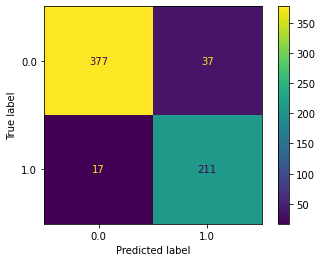

In [21]:
plot_confusion_matrix(opt, X_test_svm, y_test_svm);

In [19]:
opt.best_estimator_.named_steps['model'].support_vectors_.shape

(5165, 64)

In [22]:
dump(opt.best_estimator_, './Saved Models/svm.pkl', compress=1)

['./Saved Models/SVM.pkl']

In [23]:
# Removing unneeded variables from memory
X_train_svm = None
X_test_svm = None

y_train_svm = None
y_test_svm = None

del X_train_svm
del X_test_svm

del y_train_svm
del y_test_svm

In [132]:
saved_model = load('./models/svm.pkl')
print(saved_model.score(X_test, y_test))

0.9265536723163842


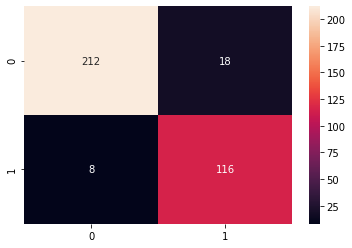

In [133]:
confusion = confusion_matrix(y_test, saved_model.predict(X_test))
sns.heatmap(confusion, annot=True, fmt='g');
saved_model = None

## Convolutional Neural Network Method

In [113]:
model = Sequential()

In [114]:
model.add(Input((128,128,1)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.000001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'AUC'])

stop = EarlyStopping(monitor='loss', patience=50)

batch_size = 64
epochs = 5_000

history = model.fit(train_gen,
                        batch_size=batch_size,
                        validation_data=validation_gen,
                        validation_steps=validation_gen.x.shape[0]/batch_size,
                        steps_per_epoch=train_gen.x.shape[0]/batch_size,
                        epochs=epochs,
                        callbacks=stop,
                        verbose=2)

Epoch 1/5000
29/28 - 1s - loss: 0.6932 - accuracy: 0.4868 - auc: 0.4982 - val_loss: 0.6930 - val_accuracy: 0.5417 - val_auc: 0.5000
Epoch 2/5000
29/28 - 1s - loss: 0.6933 - accuracy: 0.4720 - auc: 0.4855 - val_loss: 0.6928 - val_accuracy: 0.5677 - val_auc: 0.5042
Epoch 3/5000
29/28 - 1s - loss: 0.6933 - accuracy: 0.4803 - auc: 0.4916 - val_loss: 0.6926 - val_accuracy: 0.6198 - val_auc: 0.5004
Epoch 4/5000
29/28 - 1s - loss: 0.6932 - accuracy: 0.4688 - auc: 0.5199 - val_loss: 0.6922 - val_accuracy: 0.6667 - val_auc: 0.5043
Epoch 5/5000
29/28 - 1s - loss: 0.6926 - accuracy: 0.5237 - auc: 0.5465 - val_loss: 0.6919 - val_accuracy: 0.6979 - val_auc: 0.5018
Epoch 6/5000
29/28 - 1s - loss: 0.6930 - accuracy: 0.4978 - auc: 0.5484 - val_loss: 0.6921 - val_accuracy: 0.6406 - val_auc: 0.5021
Epoch 7/5000
29/28 - 1s - loss: 0.6930 - accuracy: 0.5110 - auc: 0.5228 - val_loss: 0.6920 - val_accuracy: 0.6250 - val_auc: 0.5542
Epoch 8/5000
29/28 - 1s - loss: 0.6929 - accuracy: 0.5043 - auc: 0.5309 - va

Epoch 63/5000
29/28 - 1s - loss: 0.6867 - accuracy: 0.5197 - auc: 0.7818 - val_loss: 0.6785 - val_accuracy: 0.6458 - val_auc: 0.7665
Epoch 64/5000
29/28 - 1s - loss: 0.6880 - accuracy: 0.5022 - auc: 0.7555 - val_loss: 0.6770 - val_accuracy: 0.6458 - val_auc: 0.7654
Epoch 65/5000
29/28 - 1s - loss: 0.6876 - accuracy: 0.5000 - auc: 0.7851 - val_loss: 0.6791 - val_accuracy: 0.6198 - val_auc: 0.7739
Epoch 66/5000
29/28 - 1s - loss: 0.6884 - accuracy: 0.4890 - auc: 0.7763 - val_loss: 0.6771 - val_accuracy: 0.6458 - val_auc: 0.7586
Epoch 67/5000
29/28 - 1s - loss: 0.6874 - accuracy: 0.4978 - auc: 0.7940 - val_loss: 0.6734 - val_accuracy: 0.6875 - val_auc: 0.7848
Epoch 68/5000
29/28 - 1s - loss: 0.6867 - accuracy: 0.5108 - auc: 0.7767 - val_loss: 0.6777 - val_accuracy: 0.6250 - val_auc: 0.7791
Epoch 69/5000
29/28 - 1s - loss: 0.6895 - accuracy: 0.4759 - auc: 0.7572 - val_loss: 0.6732 - val_accuracy: 0.6875 - val_auc: 0.7884
Epoch 70/5000
29/28 - 1s - loss: 0.6870 - accuracy: 0.5097 - auc: 0.7

Epoch 125/5000
29/28 - 1s - loss: 0.6702 - accuracy: 0.5482 - auc: 0.8543 - val_loss: 0.6493 - val_accuracy: 0.6719 - val_auc: 0.8563
Epoch 126/5000
29/28 - 1s - loss: 0.6692 - accuracy: 0.5334 - auc: 0.8637 - val_loss: 0.6513 - val_accuracy: 0.6458 - val_auc: 0.8703
Epoch 127/5000
29/28 - 1s - loss: 0.6684 - accuracy: 0.5528 - auc: 0.8591 - val_loss: 0.6537 - val_accuracy: 0.6302 - val_auc: 0.8602
Epoch 128/5000
29/28 - 1s - loss: 0.6726 - accuracy: 0.5226 - auc: 0.8459 - val_loss: 0.6454 - val_accuracy: 0.6615 - val_auc: 0.9097
Epoch 129/5000
29/28 - 1s - loss: 0.6708 - accuracy: 0.5388 - auc: 0.8662 - val_loss: 0.6467 - val_accuracy: 0.6823 - val_auc: 0.8614
Epoch 130/5000
29/28 - 1s - loss: 0.6680 - accuracy: 0.5506 - auc: 0.8622 - val_loss: 0.6444 - val_accuracy: 0.6979 - val_auc: 0.8863
Epoch 131/5000
29/28 - 1s - loss: 0.6675 - accuracy: 0.5362 - auc: 0.8867 - val_loss: 0.6404 - val_accuracy: 0.7031 - val_auc: 0.8809
Epoch 132/5000
29/28 - 1s - loss: 0.6691 - accuracy: 0.5528 - 

Epoch 187/5000
29/28 - 1s - loss: 0.6300 - accuracy: 0.7263 - auc: 0.8917 - val_loss: 0.5971 - val_accuracy: 0.8073 - val_auc: 0.8722
Epoch 188/5000
29/28 - 1s - loss: 0.6212 - accuracy: 0.7697 - auc: 0.8925 - val_loss: 0.6022 - val_accuracy: 0.7760 - val_auc: 0.8900
Epoch 189/5000
29/28 - 1s - loss: 0.6283 - accuracy: 0.7457 - auc: 0.8782 - val_loss: 0.5882 - val_accuracy: 0.8021 - val_auc: 0.8712
Epoch 190/5000
29/28 - 1s - loss: 0.6283 - accuracy: 0.7446 - auc: 0.8607 - val_loss: 0.5954 - val_accuracy: 0.8073 - val_auc: 0.8747
Epoch 191/5000
29/28 - 1s - loss: 0.6237 - accuracy: 0.7575 - auc: 0.8917 - val_loss: 0.5909 - val_accuracy: 0.8385 - val_auc: 0.8918
Epoch 192/5000
29/28 - 1s - loss: 0.6200 - accuracy: 0.7675 - auc: 0.8895 - val_loss: 0.5915 - val_accuracy: 0.8125 - val_auc: 0.8779
Epoch 193/5000
29/28 - 1s - loss: 0.6217 - accuracy: 0.7226 - auc: 0.8808 - val_loss: 0.5862 - val_accuracy: 0.7917 - val_auc: 0.8777
Epoch 194/5000
29/28 - 1s - loss: 0.6204 - accuracy: 0.7423 - 

Epoch 249/5000
29/28 - 1s - loss: 0.5363 - accuracy: 0.8287 - auc: 0.9074 - val_loss: 0.5175 - val_accuracy: 0.8177 - val_auc: 0.8773
Epoch 250/5000
29/28 - 1s - loss: 0.5450 - accuracy: 0.8180 - auc: 0.8922 - val_loss: 0.5072 - val_accuracy: 0.8333 - val_auc: 0.9044
Epoch 251/5000
29/28 - 1s - loss: 0.5365 - accuracy: 0.8200 - auc: 0.9026 - val_loss: 0.5033 - val_accuracy: 0.8333 - val_auc: 0.8873
Epoch 252/5000
29/28 - 1s - loss: 0.5445 - accuracy: 0.8039 - auc: 0.8938 - val_loss: 0.4944 - val_accuracy: 0.8281 - val_auc: 0.9085
Epoch 253/5000
29/28 - 1s - loss: 0.5384 - accuracy: 0.8388 - auc: 0.9039 - val_loss: 0.5060 - val_accuracy: 0.8594 - val_auc: 0.9033
Epoch 254/5000
29/28 - 1s - loss: 0.5402 - accuracy: 0.8179 - auc: 0.8979 - val_loss: 0.5008 - val_accuracy: 0.8542 - val_auc: 0.9052
Epoch 255/5000
29/28 - 1s - loss: 0.5353 - accuracy: 0.8179 - auc: 0.8989 - val_loss: 0.5111 - val_accuracy: 0.8229 - val_auc: 0.8929
Epoch 256/5000
29/28 - 1s - loss: 0.5348 - accuracy: 0.8224 - 

Epoch 311/5000
29/28 - 1s - loss: 0.4572 - accuracy: 0.8564 - auc: 0.9155 - val_loss: 0.4120 - val_accuracy: 0.8594 - val_auc: 0.9171
Epoch 312/5000
29/28 - 1s - loss: 0.4704 - accuracy: 0.8289 - auc: 0.8974 - val_loss: 0.4342 - val_accuracy: 0.8333 - val_auc: 0.9037
Epoch 313/5000
29/28 - 1s - loss: 0.4774 - accuracy: 0.8168 - auc: 0.8953 - val_loss: 0.4480 - val_accuracy: 0.8229 - val_auc: 0.8930
Epoch 314/5000
29/28 - 1s - loss: 0.4536 - accuracy: 0.8355 - auc: 0.9157 - val_loss: 0.4180 - val_accuracy: 0.8542 - val_auc: 0.9184
Epoch 315/5000
29/28 - 1s - loss: 0.4688 - accuracy: 0.8416 - auc: 0.8932 - val_loss: 0.4544 - val_accuracy: 0.8125 - val_auc: 0.8803
Epoch 316/5000
29/28 - 1s - loss: 0.4791 - accuracy: 0.8268 - auc: 0.8896 - val_loss: 0.4357 - val_accuracy: 0.8333 - val_auc: 0.9075
Epoch 317/5000
29/28 - 1s - loss: 0.4554 - accuracy: 0.8502 - auc: 0.9064 - val_loss: 0.4088 - val_accuracy: 0.8698 - val_auc: 0.9170
Epoch 318/5000
29/28 - 1s - loss: 0.4758 - accuracy: 0.8257 - 

Epoch 373/5000
29/28 - 1s - loss: 0.4346 - accuracy: 0.8362 - auc: 0.8928 - val_loss: 0.3727 - val_accuracy: 0.8542 - val_auc: 0.9308
Epoch 374/5000
29/28 - 1s - loss: 0.4257 - accuracy: 0.8465 - auc: 0.9038 - val_loss: 0.3713 - val_accuracy: 0.8646 - val_auc: 0.9253
Epoch 375/5000
29/28 - 1s - loss: 0.4314 - accuracy: 0.8246 - auc: 0.8987 - val_loss: 0.4001 - val_accuracy: 0.8490 - val_auc: 0.9197
Epoch 376/5000
29/28 - 1s - loss: 0.4020 - accuracy: 0.8432 - auc: 0.9201 - val_loss: 0.4179 - val_accuracy: 0.8438 - val_auc: 0.8976
Epoch 377/5000
29/28 - 1s - loss: 0.4344 - accuracy: 0.8333 - auc: 0.8954 - val_loss: 0.3902 - val_accuracy: 0.8490 - val_auc: 0.9182
Epoch 378/5000
29/28 - 1s - loss: 0.4320 - accuracy: 0.8362 - auc: 0.8942 - val_loss: 0.3945 - val_accuracy: 0.8490 - val_auc: 0.9066
Epoch 379/5000
29/28 - 1s - loss: 0.4298 - accuracy: 0.8465 - auc: 0.8966 - val_loss: 0.3576 - val_accuracy: 0.8906 - val_auc: 0.9442
Epoch 380/5000
29/28 - 1s - loss: 0.4069 - accuracy: 0.8405 - 

Epoch 435/5000
29/28 - 1s - loss: 0.4148 - accuracy: 0.8300 - auc: 0.8948 - val_loss: 0.3801 - val_accuracy: 0.8698 - val_auc: 0.9311
Epoch 436/5000
29/28 - 1s - loss: 0.3984 - accuracy: 0.8459 - auc: 0.9065 - val_loss: 0.3393 - val_accuracy: 0.8594 - val_auc: 0.9490
Epoch 437/5000
29/28 - 1s - loss: 0.4069 - accuracy: 0.8254 - auc: 0.9049 - val_loss: 0.3608 - val_accuracy: 0.8594 - val_auc: 0.9505
Epoch 438/5000
29/28 - 1s - loss: 0.3941 - accuracy: 0.8470 - auc: 0.9103 - val_loss: 0.3758 - val_accuracy: 0.8594 - val_auc: 0.9235
Epoch 439/5000
29/28 - 1s - loss: 0.3923 - accuracy: 0.8432 - auc: 0.9095 - val_loss: 0.4201 - val_accuracy: 0.8021 - val_auc: 0.8985
Epoch 440/5000
29/28 - 1s - loss: 0.4024 - accuracy: 0.8567 - auc: 0.9101 - val_loss: 0.3797 - val_accuracy: 0.8542 - val_auc: 0.9269
Epoch 441/5000
29/28 - 1s - loss: 0.4114 - accuracy: 0.8287 - auc: 0.8958 - val_loss: 0.3607 - val_accuracy: 0.8542 - val_auc: 0.9443
Epoch 442/5000
29/28 - 1s - loss: 0.3944 - accuracy: 0.8432 - 

Epoch 497/5000
29/28 - 1s - loss: 0.3682 - accuracy: 0.8524 - auc: 0.9207 - val_loss: 0.3731 - val_accuracy: 0.8438 - val_auc: 0.9267
Epoch 498/5000
29/28 - 1s - loss: 0.3654 - accuracy: 0.8553 - auc: 0.9216 - val_loss: 0.3668 - val_accuracy: 0.8438 - val_auc: 0.9408
Epoch 499/5000
29/28 - 1s - loss: 0.3834 - accuracy: 0.8246 - auc: 0.9110 - val_loss: 0.4111 - val_accuracy: 0.7969 - val_auc: 0.9033
Epoch 500/5000
29/28 - 1s - loss: 0.3820 - accuracy: 0.8405 - auc: 0.9114 - val_loss: 0.3601 - val_accuracy: 0.8594 - val_auc: 0.9444
Epoch 501/5000
29/28 - 1s - loss: 0.3879 - accuracy: 0.8355 - auc: 0.9087 - val_loss: 0.3179 - val_accuracy: 0.8698 - val_auc: 0.9501
Epoch 502/5000
29/28 - 1s - loss: 0.3737 - accuracy: 0.8481 - auc: 0.9185 - val_loss: 0.3882 - val_accuracy: 0.8333 - val_auc: 0.9319
Epoch 503/5000
29/28 - 1s - loss: 0.3700 - accuracy: 0.8553 - auc: 0.9191 - val_loss: 0.3592 - val_accuracy: 0.8438 - val_auc: 0.9368
Epoch 504/5000
29/28 - 1s - loss: 0.3851 - accuracy: 0.8476 - 

Epoch 559/5000
29/28 - 1s - loss: 0.3697 - accuracy: 0.8491 - auc: 0.9144 - val_loss: 0.3363 - val_accuracy: 0.8490 - val_auc: 0.9460
Epoch 560/5000
29/28 - 1s - loss: 0.3809 - accuracy: 0.8438 - auc: 0.9101 - val_loss: 0.3575 - val_accuracy: 0.8542 - val_auc: 0.9396
Epoch 561/5000
29/28 - 1s - loss: 0.3995 - accuracy: 0.8351 - auc: 0.9001 - val_loss: 0.3617 - val_accuracy: 0.8542 - val_auc: 0.9478
Epoch 562/5000
29/28 - 1s - loss: 0.3642 - accuracy: 0.8470 - auc: 0.9194 - val_loss: 0.3799 - val_accuracy: 0.8281 - val_auc: 0.9413
Epoch 563/5000
29/28 - 1s - loss: 0.3670 - accuracy: 0.8427 - auc: 0.9176 - val_loss: 0.3832 - val_accuracy: 0.8438 - val_auc: 0.9371
Epoch 564/5000
29/28 - 1s - loss: 0.3744 - accuracy: 0.8502 - auc: 0.9137 - val_loss: 0.3199 - val_accuracy: 0.8854 - val_auc: 0.9616
Epoch 565/5000
29/28 - 1s - loss: 0.3974 - accuracy: 0.8222 - auc: 0.8977 - val_loss: 0.3658 - val_accuracy: 0.8333 - val_auc: 0.9442
Epoch 566/5000
29/28 - 1s - loss: 0.3584 - accuracy: 0.8509 - 

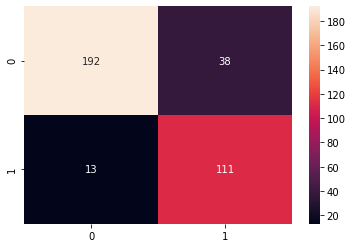

In [131]:
confusion = confusion_matrix(y_test, np.round(model.predict(X_test)).reshape(-1))
sns.heatmap(confusion, annot=True, fmt='g');

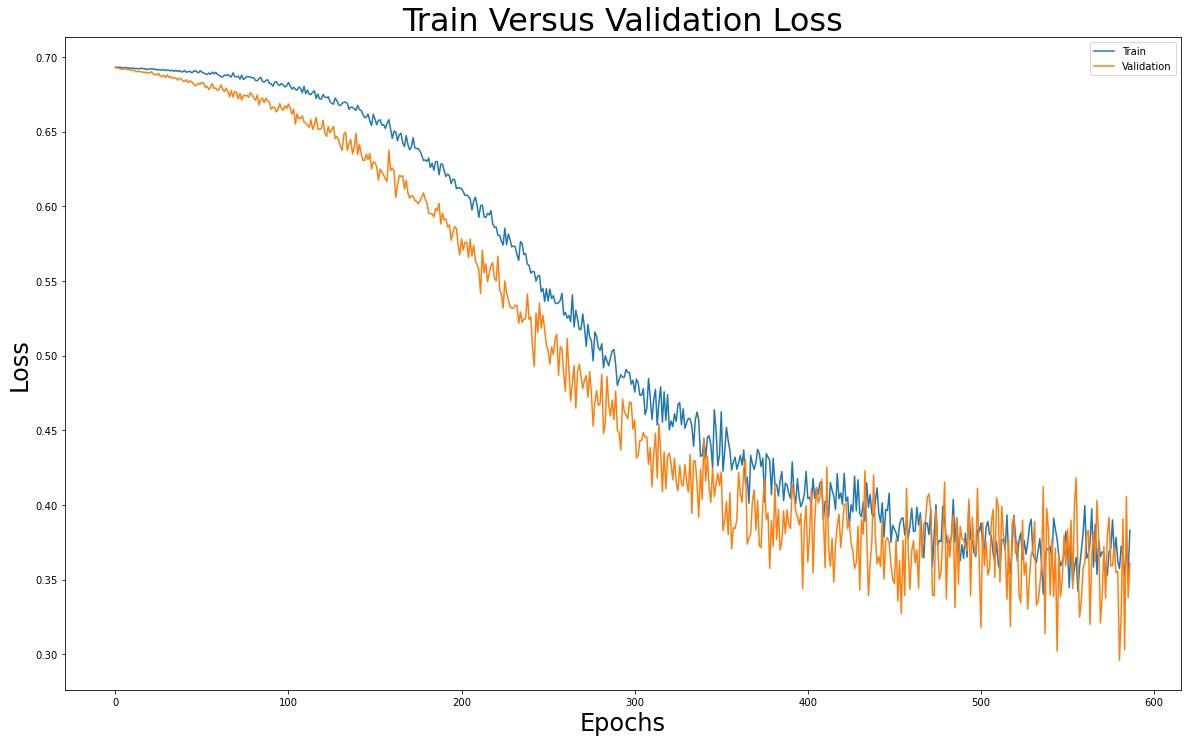

In [115]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.legend(['Train', 'Validation']);
plt.xlabel('Epochs', fontdict={'fontsize':24});
plt.ylabel('Loss', fontdict={'fontsize':24});
plt.title('Train Versus Validation Loss', fontdict={'fontsize':32});

In [117]:
model.evaluate(X_test, y_test)

12/12 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8750 - auc: 0.94 - ETA: 0s - loss: 0.3534 - accuracy: 0.8551 - auc: 0.94 - 0s 5ms/step - loss: 0.3525 - accuracy: 0.8559 - auc: 0.9421


[0.35245221853256226, 0.8559321761131287, 0.9420932531356812]

In [111]:
def save_keras_model(model, filename):

    converter = tf_lite.TFLiteConverter.from_keras_model(model)

    lite_model = converter.convert()

    with open(f'./Saved Models/{filename}.tflite', 'wb') as f:
        f.write(lite_model)

    model_loaded = tf_lite.Interpreter(model_path=f'./Saved Models/{filename}.tflite')

In [118]:
save_keras_model(model, 'cnn')

INFO:tensorflow:Assets written to: C:\Users\ianan\AppData\Local\Temp\tmpk2qmcknq\assets


INFO:tensorflow:Assets written to: C:\Users\ianan\AppData\Local\Temp\tmpk2qmcknq\assets


## Fine Tuning CNN

In [16]:
filters_min = 32
filters_max = 256
pool_min = 2
pool_max = 4
kernel_min = 3
kernel_max = 9


class CNN_HyperModel(HyperModel):
    
    def build(self, hp):
        
        model = Sequential()
        
        model.add(Input((128,128,1)))
        
        model.add(Conv2D(filters=hp.Int('filters1', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels1', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool1', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Conv2D(filters=hp.Int('filters2', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels2', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters3', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels3', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool2', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Conv2D(filters=hp.Int('filters4', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels4', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters5', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels5', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(Conv2D(filters=hp.Int('filters6', min_value=filters_min, max_value=filters_max, step=32),
                         kernel_size=hp.Int('kernels6', min_value=kernel_min, max_value=kernel_max, step=2),
                         strides=1,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=hp.Int('pool3', min_value=pool_min, max_value=pool_max, step=1)))
        
        model.add(Flatten())
        
        model.add(Dense(hp.Int('dense1', min_value=64, max_value=512, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout1', min_value=0, max_value=.5, step=.1)))

        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Float('adam1',
            min_value=1e-6, max_value=1e-2, sampling='LOG')), metrics=['accuracy', 'AUC'])
        
        return model

In [17]:
hypermodel = CNN_HyperModel()

hyperband = Hyperband(hypermodel, objective='loss', max_epochs=200, seed=42)

In [18]:
hyperband.search(x = train_gen, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [109]:
model = hyperband.get_best_models(num_models=1)[0]

In [99]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 224)       129248    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       258176    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 96)        602208    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 160)       1

In [105]:
model.evaluate(validation_gen)

12/12 [==============================] - ETA: 0s - loss: 1.4591 - accuracy: 0.9375 - auc: 0.96 - ETA: 0s - loss: 0.5167 - accuracy: 0.9688 - auc: 0.98 - ETA: 0s - loss: 0.3643 - accuracy: 0.9688 - auc: 0.98 - 0s 12ms/step - loss: 0.3601 - accuracy: 0.9633 - auc: 0.9844


[0.3600925803184509, 0.9632768630981445, 0.9844493865966797]

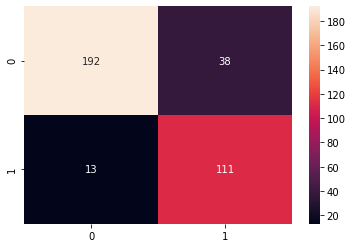

In [130]:
confusion = confusion_matrix(y_test, np.round(model.predict(X_test)).reshape(-1))
sns.heatmap(confusion, annot=True, fmt='g');

In [112]:
save_keras_model(model, 'tuned_cnn')

INFO:tensorflow:Assets written to: C:\Users\ianan\AppData\Local\Temp\tmp8iwee5pv\assets


INFO:tensorflow:Assets written to: C:\Users\ianan\AppData\Local\Temp\tmp8iwee5pv\assets


## Tensorflow Lite

In [129]:
model_loaded = tf_lite.Interpreter(model_path="./Saved Models/tuned_cnn.tflite")

input_details = model_loaded.get_input_details()
output_details = model_loaded.get_output_details()

model_loaded.resize_tensor_input(input_details[0]['index'], (32, 128, 128, 1))
model_loaded.resize_tensor_input(output_details[0]['index'], (32, 1))
model_loaded.allocate_tensors()

val_batch, val_label = validation_gen.next()
model_loaded.set_tensor(input_details[0]['index'], val_batch)
model_loaded.invoke()

model_preds = model_loaded.get_tensor(output_details[0]['index'])
print("Prediction results shape:", model_preds.shape)
print('ROC AUC Score: ', roc_auc_score(val_label, model_preds))

Prediction results shape: (32, 1)
ROC AUC Score:  0.9958333333333333
